<a href="https://colab.research.google.com/github/sedaoturak/Quantum_Espresso_Colab/blob/main/Quantum_Espresso_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📥 Install the Quantum Espresso

In [1]:
# eliminate text output during installation
%%capture

# install mathematical libraries to peform fast Fourier transforms
! apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc

In [4]:
# eliminate text output during installation
%%capture

# download the pre-compiled files in compressed format
!gdown 'https://drive.google.com/file/d/1ceDBUF2neoI2Jrnk5EWvWrxLuy1Y-9lT/view?usp=share_link' -O qe-lite.tgz

# unpack the compressed files
! tar -xvzf qe-lite.tgz

# clean up some files
! rm -rf sample_data qe-lite.tgz

Install `ase` for preparing input files, reading output files and visualization

In [5]:
%%capture
!apt install ase

# 📝 Prepare the input file

In [7]:
# create a folder and navigate into it
%mkdir -p /content/silicon
%cd /content/silicon/

# create input and write it into a file
qe_input = """
&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon'
/
&system
  ibrav = 2,
  celldm(1) = 10.26,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 120.0,
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
Si 28.086 Si.upf

K_POINTS automatic
1 1 1 0 0 0

ATOMIC_POSITIONS (alat)
  Si 0.0 0.0 0.0
  Si 0.25 0.25 0.25

"""

with open("Si.scf.in", "w") as f:
    f.write(qe_input)

# print the content of the input file to check the parameters
! cat Si.scf.in

/content/silicon

&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon'
/
&system
  ibrav = 2,
  celldm(1) = 10.26,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 120.0,
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
Si 28.086 Si.upf

K_POINTS automatic
1 1 1 0 0 0

ATOMIC_POSITIONS (alat)
  Si 0.0 0.0 0.0
  Si 0.25 0.25 0.25



🔎 Visualize the silicon atoms

In [12]:
from ase.io import read
from ase.visualize import view

# upload structure from Quantum Espresso file
atoms = read('Si.scf.in', format='espresso-in')
# visualize it in rendered 3D version
view(atoms,viewer='x3d')

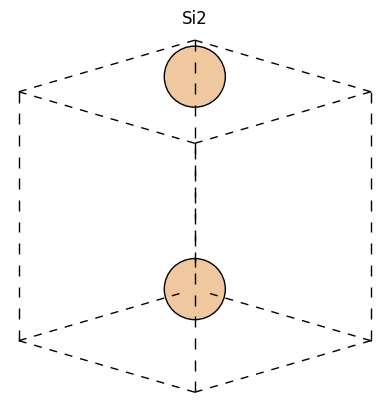

In [11]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

# visualize the structure in 2D
fig, ax = plt.subplots()
plot_atoms(atoms, ax, radii=0.3, rotation=('45x,45y,90z'))
ax.set_title(atoms.get_chemical_formula())
ax.set_axis_off()
plt.show()

# ⚛ Run the DFT calculation

In [ ]:
# run the pw.x executable
! /content/qe-lite/bin/pw.x < Si.scf.in > Si.scf.out

## print the output file

In [14]:
!cat Si.scf.out


     Program PWSCF v.7.4 starts on  6Jan2026 at 18: 2:45 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8544 MiB available memory on the printing compute node when the environment starts

     Waiting for input...
     Reading input from standard input

     Current dimensions of program PWSCF are:
     Max number of different atomic species (ntypx) = 10
     Max number of k-points (npk) =  40000
     Max angular momentum in pseudopotentials (lmaxx) =  4


     G-vector sticks info
     --------------------


In [22]:
# read the total energy in the SCF output file by linux command
!grep "!" Si.scf.out

!    total energy              =     -21.58711152 Ry


In [23]:
from ase.io import read
# read the total energy in the SCF output file by ase
output = read("/content/silicon/Si.scf.out")
output.get_total_energy()

-293.70758905973685

# 🛠️ Convergence test (cut-off energy)

In [26]:
import numpy as np
import ase.io
import re
import os

# Base input template from your Si.scf.in file
qe_input = """&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon'
/
&system
  ibrav = 2,
  celldm(1) = 10.26,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 120.0,
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
Si 28.086 Si.upf

K_POINTS automatic
1 1 1 0 0 0

ATOMIC_POSITIONS (alat)
  Si 0.0 0.0 0.0
  Si 0.25 0.25 0.25
"""

# Create a list for cutoff energies to be tested
cutoff_energies = np.arange(12, 54, 4)
total_energies = []

for cutoff in cutoff_energies:
    # 1. Define unique filenames for this specific cutoff
    input_file = f"Si_{cutoff}.scf.in"
    output_file = f"Si_{cutoff}.scf.out"

    # 2. Update the input content using regex to find 'ecutwfc = value'
    updated_input = re.sub(r"ecutwfc\s*=\s*[\d\.]+", f"ecutwfc = {float(cutoff)}", qe_input)

    # 3. Save the unique input file
    with open(input_file, "w") as f:
        f.write(updated_input)

    # 4. Run the simulation
    print(f"Running simulation for ecutwfc = {cutoff} Ry...")
    ! /content/qe-lite/bin/pw.x < {input_file} > {output_file}

    # 5. Read the unique output file and record the total energy
    try:
        results = ase.io.read(output_file)
        energy = results.get_total_energy()
        total_energies.append(energy)
        print(f"Completed. Total Energy: {energy} Ry")
    except Exception as e:
        print(f"Error reading {output_file}: {e}")
        total_energies.append(None)

print(f"################################")
# Display results
for c, e in zip(cutoff_energies, total_energies):
    print(f"Cutoff: {c} Ry | Total Energy: {e} eV")

Running simulation for ecutwfc = 12 Ry...
Completed. Total Energy: -293.3822641762736 eV
Running simulation for ecutwfc = 16 Ry...
Completed. Total Energy: -293.5765082861765 eV
Running simulation for ecutwfc = 20 Ry...
Completed. Total Energy: -293.6511940109031 eV
Running simulation for ecutwfc = 24 Ry...
Completed. Total Energy: -293.6978707861031 eV
Running simulation for ecutwfc = 28 Ry...
Completed. Total Energy: -293.7043985249786 eV
Running simulation for ecutwfc = 32 Ry...
Completed. Total Energy: -293.7100029815996 eV
Running simulation for ecutwfc = 36 Ry...
Completed. Total Energy: -293.71034434841016 eV
Running simulation for ecutwfc = 40 Ry...
Completed. Total Energy: -293.7108410922226 eV
Running simulation for ecutwfc = 44 Ry...
Completed. Total Energy: -293.7114118509992 eV
Running simulation for ecutwfc = 48 Ry...
Completed. Total Energy: -293.71167131154436 eV
Running simulation for ecutwfc = 52 Ry...
Completed. Total Energy: -293.7121245171426 eV
Cutoff: 12 Ry | Tot

Text(0, 0.5, 'Total Energy (Ry)')

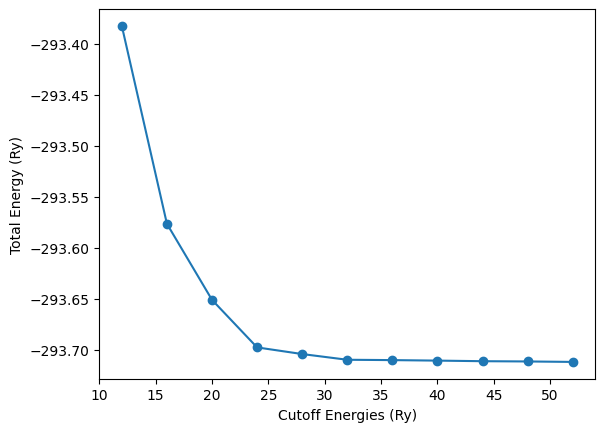

In [28]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

ax.plot(cutoff_energies, total_energies,'o-')
ax.set_xlabel('Cutoff Energies (Ry)')
ax.set_ylabel('Total Energy (eV)')

# ⊞ Lattice parameter

In [29]:
import numpy as np
import ase.io
import re
import os

# Base input template (assuming qe_input is defined from your previous Si.scf.in)
qe_input = """&control
  prefix='silicon',
  pseudo_dir = '/content/qe-lite/pseudopotentials',
  outdir='/content/silicon'
/
&system
  ibrav = 2,
  celldm(1) = 10.26,
  nat = 2,
  ntyp = 1,
  ecutwfc = 30.0,
  ecutrho = 120.0,
/
&electrons
  conv_thr = 1e-8,
/
ATOMIC_SPECIES
Si 28.086 Si.upf

K_POINTS automatic
1 1 1 0 0 0

ATOMIC_POSITIONS (alat)
  Si 0.0 0.0 0.0
  Si 0.25 0.25 0.25
"""

# Define the range of lattice constants to test
lattice_constants = np.arange(9.5, 11.1, 0.1)
total_energies = []

for constant in lattice_constants:
    # Create unique filenames for this specific iteration
    c_str = f"{constant:.2f}"
    input_file = f"Si_lat_{c_str}.scf.in"
    output_file = f"Si_lat_{c_str}.scf.out"

    # Use Regex to replace celldm(1) value
    updated_input = re.sub(r"celldm\(1\)\s*=\s*[\d\.]+", f"celldm(1) = {constant:.4f}", qe_input)

    # Save the specific input file
    with open(input_file, "w") as f:
        f.write(updated_input)

    # Run the Quantum Espresso simulation
    print(f"Running simulation for celldm(1) = {constant:.2f} Bohr...")
    ! /content/qe-lite/bin/pw.x < {input_file} > {output_file}

    # Parse the unique output file
    try:
        results = ase.io.read(output_file)
        energy = results.get_total_energy()
        total_energies.append(energy)
        print(f"Success. Energy: {energy} eV")
    except Exception as e:
        print(f"Error reading {output_file}: {e}")
        total_energies.append(None)

# Print summary of results
print("##################################")
for c, e in zip(lattice_constants, total_energies):
    print(f"Lattice Constant: {c:.2f} Bohr | Total Energy: {e} eV")

Running simulation for celldm(1) = 9.50 Bohr...
Success. Energy: -290.1240340257107 eV
Running simulation for celldm(1) = 9.60 Bohr...
Success. Energy: -290.7497861927418 eV
Running simulation for celldm(1) = 9.70 Bohr...
Success. Energy: -291.32319236485824 eV
Running simulation for celldm(1) = 9.80 Bohr...
Success. Energy: -291.8471655207031 eV
Running simulation for celldm(1) = 9.90 Bohr...
Success. Energy: -292.32480653352457 eV
Running simulation for celldm(1) = 10.00 Bohr...
Success. Energy: -292.7608146732594 eV
Running simulation for celldm(1) = 10.10 Bohr...
Success. Energy: -293.15530912576895 eV
Running simulation for celldm(1) = 10.20 Bohr...
Success. Energy: -293.511189400061 eV
Running simulation for celldm(1) = 10.30 Bohr...
Success. Energy: -293.83204603823657 eV
Running simulation for celldm(1) = 10.40 Bohr...
Success. Energy: -294.1188664053593 eV
Running simulation for celldm(1) = 10.50 Bohr...
Success. Energy: -294.3769383535988 eV
Running simulation for celldm(1) =

Text(0, 0.5, 'Total Energy (Ry)')

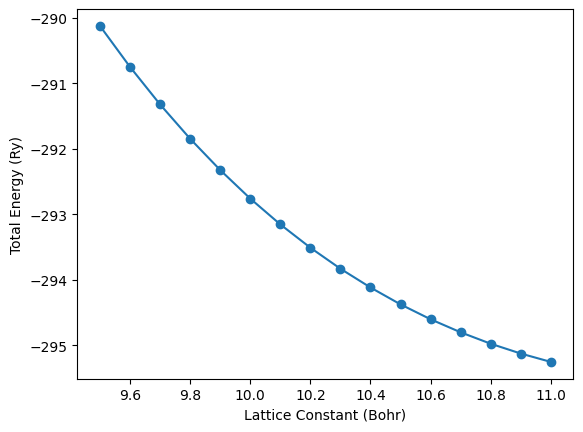

In [31]:
fig,ax = plt.subplots()

ax.plot(lattice_constants, total_energies,'o-')
ax.set_xlabel('Lattice Constant (Bohr)')
ax.set_ylabel('Total Energy (eV)')